# W207 Final Project Baseline: OpenBarbell

## 30 July 2018

### Project Description

OpenBarbell is a device that measures key weightlifting metrics during a lifter's workout. Example metrics are weight, peak velocity, and rep time. These metrics can be used by a lifter to better understand and improve their performance. The goal of this project is to use the data produced by OpenBarbell to add greater intelligence to the user experience.

### Project Goals

 1. *Exercise classification*. Exercise name is an open field (lifters can enter whatever they want or nothing at all). However, it is one of the key variables to analyze lifter performance. Hence, we would like to build an algorithm to determine exercise for each set based on its characteristics (weight, range of motion, velocity etc.)
 2. *Lifter segmentation*. Can we create distinct groups of lifters based on their lifting characteristics for each exercise (velocity, range of motion, weight)? This would help create semi-customized training programs.

### Data and Source

 - [OpenBarbell Data](https://github.com/squatsandsciencelabs/OpenBarbell-V3/wiki/OpenBarbell-Data-Storage-Format) - the dataset is provided by Squats and Science Barbell, no NDA is required per owner (Jordan Berke)
 - [Project GitHub Repository](https://github.com/YuliaZamriy/W207_Group_Project)

### Team
 - Renzee Reyes
 - Tim Witthoefft
 - Jack Workman
 - Yulia Zamriy
 
## Summary, Next Steps, and Open Questions at the Bottom

In [1]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import locale
from locale import atof
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

csv_data_file = 'ob_data_w207_filtered.csv'
zip_data_file = 'ob_data_w207_filtered.zip'

locale.setlocale(locale.LC_NUMERIC, '')

'English_United States.1252'

# 1. Import The Data

The data exists as a CSV encased in a zip file. Here, we unzip if not already unzipped and load the data file with pandas.

## 1.1 Note on CSV Data

The CSV data imported here is modified slightly from the original data source. The original data source is in JSON and contains 'deleted' or 'removed' observations that the devices recorded but the user did not want to retain. Since we do not know why the users deleted these rows (deletion could have been an accident, the user recognized the data was incorrect, etc), we have elected to not include these in our model.

Other data processing operations not seen in this notebook include:
- filtering exercises to "big 3" - squat, bench press, and deadlift
- converting certain fields from strings to datetime and numeric objects
- handle numbers with a comma as a decimal point
- converting 'weight' to lbs
- some outlier processing

The script used to do this pre-processing can be seen here: https://github.com/YuliaZamriy/W207_Group_Project/blob/master/OBDB_processing_v2.py

## 1.2 Import

In [2]:
df = None
if not os.path.exists(csv_data_file) and os.path.exists(zip_data_file):
    zip_ref = zipfile.ZipFile(zip_data_file, 'r')
    zip_ref.extractall('\\')
    zip_ref.close()
if os.path.exists(csv_data_file):
    df = pd.read_csv(csv_data_file)
    # -- pandas supposedly coverts '7,39' to '7.39' with decimal arg but it didn't work
    #df = pd.read_csv(csv_data_file, decimal='.')
else:
    raise Exception('Data file not found! {0}'.format(csv_data_file))

# 2. Quick EDA

To ensure that the data contains no hidden surprises, we do a quick EDA.

## 2.1 Shape and Head

In [3]:
print("Data shape: {0}".format(df.shape))

Data shape: (292910, 45)


In [4]:
df.head()

,_id,deleted,endTime,exercise,initialStartTime,metric,removed_set,rpe,setID,setNumber,...,TimeRepWait,SlowAllow,Backlight,MinAllow,PeakAccel,_merge,rpe_num,weight_lbs,exercise_clean,exercise_clean2
0,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,...,0.0,130000.0,10000.0,150000.0,11.073610,both,7.5,192.90425,bench,bench
1,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,...,0.0,130000.0,10000.0,150000.0,0.714399,both,7.5,192.90425,bench,bench
2,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,...,0.0,130000.0,10000.0,150000.0,0.730685,both,7.5,192.90425,bench,bench
3,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,...,0.0,130000.0,10000.0,150000.0,0.923557,both,7.5,192.90425,bench,bench
4,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,...,0.0,130000.0,10000.0,150000.0,0.827607,both,7.5,192.90425,bench,bench


## 2.2 Check for Null Values

Here we observe that there are, in fact, quite a few null values in the dataset. Prior domain knowledge tells us that most of this is because the dataset is a combination of observations from multiple versions of the OpenBarbell platform and that older versions do not support some of the newer fields (like videoURL).

The majority of null values seen here can be safely ignored. However, some, like PeakAccel, will need to be handled. We do this in Section 3.

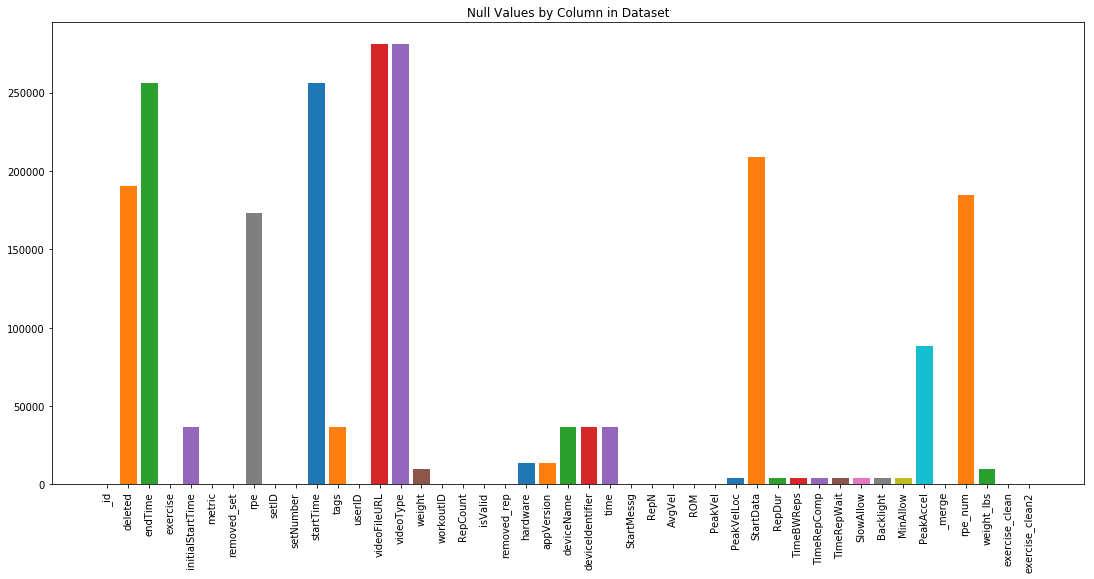

In [5]:
null_sums = df.isnull().sum()
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)
for i, null_col in enumerate(null_sums):
    plt.bar(i, null_col)

_ = plt.title('Null Values by Column in Dataset')
_ = plt.xticks(list(range(len(null_sums))), null_sums.index, rotation='vertical')

# 3. Clean and Feature Engineer the Data

## 3.1 Clean the Data

There are many columns in the dataset that are not especially important. The first step is to drop those. Then, the outcome column must be factorized. We also drop all nulls for the purpose of this notebook. This approach might be improved as the project progresses.

In [6]:
LABEL_COLUMN = 'exercise_clean'
DATA_COLUMNS = ['RepCount', 'AvgVel',
                 'ROM', 'PeakVel', 'PeakVelLoc', 'RepDur', 'TimeBWReps',
                 'TimeRepComp', 'TimeRepWait', 'PeakAccel', 'weight_lbs']

In [8]:
def clean_data(data):

    # keep only the columns we care about
    data = data[[LABEL_COLUMN] + DATA_COLUMNS]

    # convert nums with commas to decimals
    # https://stackoverflow.com/questions/24037507/converting-string-objects-to-int-float-using-pandas
    # data['weight'] = pd.to_numeric(data['weight'], errors='coerce')
    
    # convert categorical labels to ints
    # https://stackoverflow.com/questions/47595268/convert-classes-to-numeric-in-a-pandas-dataframe
    data[LABEL_COLUMN] = pd.factorize(data[LABEL_COLUMN])[0]
    # todo: figure out what nums match to which label
    
    # remove nulls
    data = data.dropna()
    
    return data

# -- will be useful for categorical data! but not for labels as it creates a col for each unique label
## http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/
#d = pd.DataFrame({'a': [11, 22, 33, 55], 'b': ['one', 'two', 'three', 'five']})
#pd.get_dummies(d, columns=['b'])
#print(d)

In [9]:
print('Observations before cleaning = {0}'.format(df.shape))
df_cleaned = clean_data(df)
print('Observations after cleaning = {0}'.format(df_cleaned.shape))

Observations before cleaning = (292910, 45)
Observations after cleaning = (196034, 12)


c:\python36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


## 3.2 Feature Engineering

Todo!

In [10]:
def feature_engineer_data(data):
    # todo
    return data

In [12]:
print('Observations before feature engineering = {0}'.format(df_cleaned.shape))
df_cleaned_and_engineered = feature_engineer_data(df_cleaned)
print('Observations after feature engineering = {0}'.format(df_cleaned.shape))

df_labels = df_cleaned_and_engineered[LABEL_COLUMN]
df_data = df_cleaned_and_engineered.drop(LABEL_COLUMN, axis=1)

Observations before feature engineering = (196034, 12)
Observations after feature engineering = (196034, 12)


# 4. Separate Data Into Train, Dev, & Test Sets

For this project, we are splitting the dataset into the following three categories:
1. Train - 80%
2. Dev - 10%
3. Test - 10%

Train will be used to train the model. We will use Dev to test our pipeline and model modifications. We will use Test as a final checkpoint of model performance.


In [13]:
n = len(df)
dev_pct = .1
dev_cnt = int(n * dev_pct)
test_pct = .1
test_cnt = int(n * test_pct)
dev_data, dev_labels = df_data[:dev_cnt], df_labels[:dev_cnt]
test_data, test_labels = df_data[dev_cnt:dev_cnt+test_cnt], df_labels[dev_cnt:dev_cnt+test_cnt]
train_data, train_labels = df_data[dev_cnt+test_cnt:], df_labels[dev_cnt+test_cnt:]

print('Dev data & labels shapes: {0}, {1}'.format(dev_data.shape, dev_labels.shape))
print('Test data & labels shapes: {0}, {1}'.format(test_data.shape, test_labels.shape))
print('Train data & labels shapes: {0}, {1}'.format(train_data.shape, train_labels.shape))

Dev data & labels shapes: (29291, 11), (29291,)
Test data & labels shapes: (29291, 11), (29291,)
Train data & labels shapes: (137452, 11), (137452,)


# 5. Train and Test the Model

Using a K Nearest Neighbors classifier, we train the model using the train dataset and evaluate its performance on the dev dataset. We use the dev dataset to determine the optimal value of k.

In [14]:
def do_knn(k, train_data, train_labels, dev_data, dev_labels):
    knn_clsf = KNeighborsClassifier(k)
    knn_clsf.fit(train_data, train_labels)
    y_pred = knn_clsf.predict(dev_data)
    accuracy = knn_clsf.score(dev_data, dev_labels)
    return knn_clsf, accuracy

In [15]:
knn_clsf, acc = do_knn(1, train_data, train_labels, dev_data, dev_labels)
print(acc)

0.3100269707418661


In [16]:
accuracies = list()
for k in range(1, 10, 1):
    knn_clsf, accuracy = do_knn(k, train_data, train_labels, dev_data, dev_labels)
    print(k, accuracy)
    accuracies.append(accuracy)

1 0.3100269707418661
2 0.34112867433682703
3 0.3587108668191595
4 0.36052029633675875
5 0.36396845447407056
6 0.36809941620292924
7 0.374415349424738
8 0.3754395548120583
9 0.37537127445290364


In [18]:
optimal_k = accuracies.index(max(accuracies)) + 1  # k values start at 1 but array indicies start at 0
print('Best KNN is k={0} with accuracy of {1:.2f}%'.format(optimal_k, accuracies[optimal_k] * 100))

Best KNN is k=8 with accuracy of 37.54%


# 6. Model Performance

Finally, we use the optimal k value determined in Section 5 to test the performance of our model on the Test dataset.

In [19]:
knn_clsf, accuracy = do_knn(optimal_k, train_data, train_labels, test_data, test_labels)
print('Model Accuracy at Exercise Classification = {0}'.format(accuracy))

Model Accuracy at Exercise Classification = 0.36297838926632753


# Summary

Our group has successfully put together a pipeline where we can rapidly iterate on improving our model. The remaining time before submission will be spent analyzing, iterating, and improving our model's performance.

# Next Steps

- Continue analyzing the data to improve cleaning and feature engineering
- Explore additional machine learning algorithms to determine which is best for this dataset and problem
- Develop a more robust method of scoring performance to guide what needs to be improved in the pipeline and model
- Apply an unsupervised algorithm for Goal #2: Lifter Segmentation

# Open Questions

- What model algorithm gives the best performance and why?
- Filtering to "Big 3" lifts leaves us with two options for labels: 'exercise_clean' and 'exercise_clean2'. Which is better and why?
- What's the best way to handle null values?